# Jupyter notebook sample

In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



# Introduction
Finding the optimum time to go to the gym. There's historical time series data about how busy the college gym has been on a 10 minute basis available. We'll find out the best days to go to the gym



In [4]:
gym_data = pd.read_csv('crowdness_gym_data.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_37148\3940400036.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  gym_data['datetime'] = pd.to_datetime(gym_data['date'])


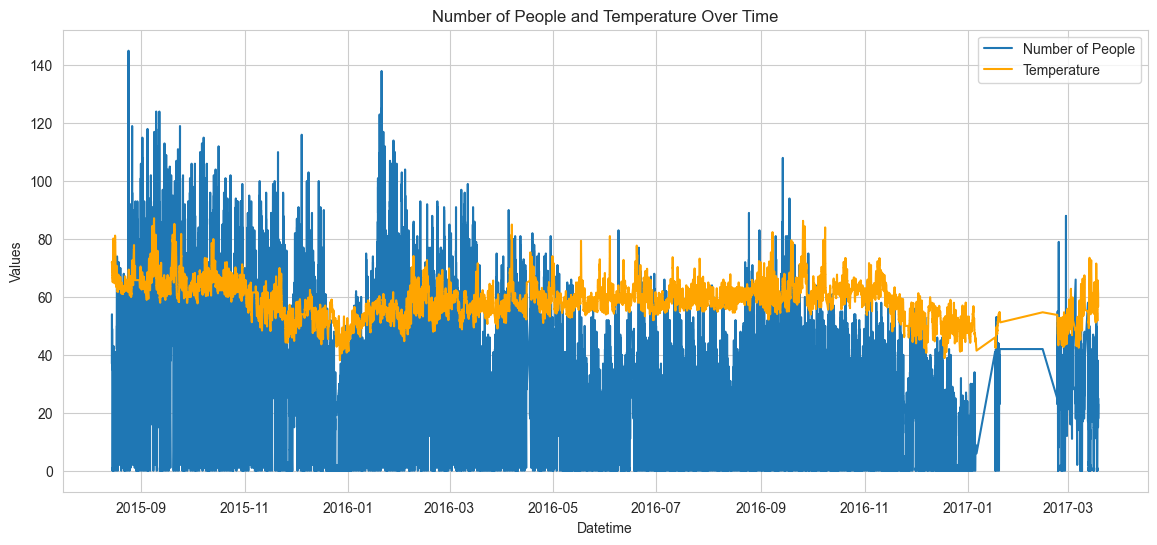

In [8]:
# Convert 'date' column to a datetime column
gym_data['datetime'] = pd.to_datetime(gym_data['date'])

# Plotting the number of people and temperature as a function of the new datetime column
plt.figure(figsize=(14, 6))
sns.lineplot(data=gym_data, x='datetime', y='number_people', label='Number of People')
sns.lineplot(data=gym_data, x='datetime', y='temperature', label='Temperature', color='orange')
plt.title('Number of People and Temperature Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.show()

The dataframe contains several columns

- **number_people**: this is the number of people at the gym at each observation. This will be our target variable or label.
- date: a string value with the specific date and time information.
- timestamp: an integer (int), with the number of seconds since the start of the day (00:00).
- dayofweek: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.
- is_weekend: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.
- is_holiday: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.
- temperature: a float, defining the temperature during the day of the observation in Fahrenheit.
- isstartof_semester: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.
- is_during_semester: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.
- month: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.
- hour: an integer (int) for the hour of the day from 0 to 23.